----
# I. Data preprocessing

## 1. Read dataset

In [1]:
import pandas as pd

origin_train = pd.read_csv("dataset/train.csv")
origin_test = pd.read_csv("dataset/test.csv")
submission = pd.read_csv("dataset/sample_submission.csv")

## 2. Missing values handling

### a) `train.csv`

In [2]:
def means(df):
    res = {}
    for i in range(1, 6):
        res[f"Promotion{i}"] = df[f"Promotion{i}"].mean()
    return res


def medians(df):
    res = {}
    for i in range(1, 6):
        res[f"Promotion{i}"] = df[f"Promotion{i}"].median()
    return res


train = origin_train.fillna(0)

### b) `test.csv`

In [3]:
test = origin_test.fillna(value=means(origin_test))

## 3. Data manipulation

### a) `Date`

In [4]:
import datetime as dt


def date_to_week(date):
    day, month, year = map(int, date.split('/'))
    t = dt.datetime(year, month, day) - dt.datetime(2010, 2, 5)
    return int(t.days // 7)


def date_split(date):
    return tuple(map(int, date.split('/')))


# train
origin_train['Week'] = origin_train['Date'].apply(date_to_week)
train["Day"] = train["Date"].apply(lambda x: date_split(x)[0])
train["Month"] = train["Date"].apply(lambda x: date_split(x)[1])
train["Year"] = train["Date"].apply(lambda x: date_split(x)[2])


# test
origin_test['Week'] = origin_test['Date'].apply(date_to_week)
test["Day"] = test["Date"].apply(lambda x: date_split(x)[0])
test["Month"] = test["Date"].apply(lambda x: date_split(x)[1])
test["Year"] = test["Date"].apply(lambda x: date_split(x)[2])

### b) `IsHoliday`

In [5]:
# trian
train["IsHoliday"] = train["IsHoliday"].apply(int)

# test
test["IsHoliday"] = test["IsHoliday"].apply(int)

### c) `Store`

In [6]:
diff = [28,30,33,35,36,38,42,43,44]


def trend_check(store):
    if store in {36}:
        return 1
    elif store in {38,44}:
        return 2
    elif store in {28,33,42,43}:
        return 3
    elif store in {30,35}:
        return 4
    return 0


train['Trend'] = train['Store'].apply(trend_check)
test['Trend'] = test['Store'].apply(trend_check)


train = pd.get_dummies(data=train, columns=['Trend'])
train = pd.get_dummies(data=train, columns=['Store'])

test = pd.get_dummies(data=test, columns=['Trend'])
test = pd.get_dummies(data=test, columns=['Store'])

### d) `Promotion1`, ... , `Promotion5`

In [7]:
# Scaling
from sklearn.preprocessing import RobustScaler


promos = ['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5']

scaler = RobustScaler()
scaler.fit(train[promos])
train[promos] = scaler.transform(train[promos])
test[promos] = scaler.transform(test[promos])

### e) `Weekly_Sales`

In [8]:
import numpy as np


train["Weekly_Sales"] = np.log1p(train["Weekly_Sales"])

## 4. Remove not using features

In [9]:
removes = ['id','Date','Temperature']

train = train.drop(columns=removes)
test = test.drop(columns=removes)

----
# II. Modeling

## 1. Divide `train.csv` into training data and for predicting data

In [10]:
x_train = train.drop(columns=["Weekly_Sales"])
y_train = train["Weekly_Sales"]

## 2. Choose a suitable model

In [11]:
predictions = {}

### a) XGBoost

In [12]:
import time
import xgboost as xgb


start_t = time.time()

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    learning_rate=0.1, 
    max_depth = 5, 
    n_estimators = 1500
)
model.fit(x_train, y_train)

y_pred = np.expm1(model.predict(test))
predictions["XGBoost"] = y_pred


print(f"[XGBoost] => time: {round(time.time() - start_t, 2)}(sec)")
print(f"{y_pred[0]}, {y_pred[1]}, ... , {y_pred[-1]}")

[XGBoost] => time: 3.74(sec)
1658085.25, 1515478.125, ... , 781429.875


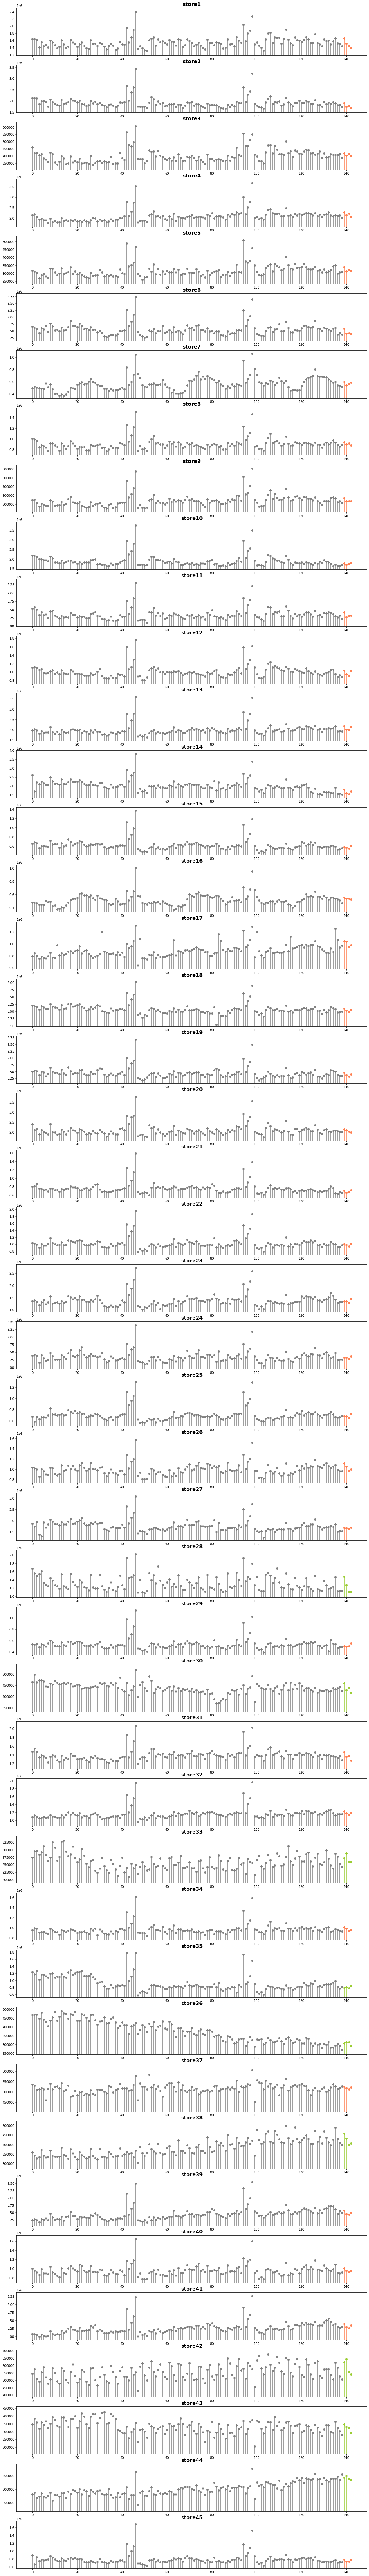

In [13]:
import matplotlib.pyplot as plt


def split(df):
    store = {}
    for i in range(1, 46):
        store[i] = df[df['Store'] == i]
    return store


past = split(origin_train)
tmp = origin_test.copy()
tmp['Weekly_Sales_Pred'] = y_pred
future = split(tmp)
fig = plt.figure(figsize=(20, 150))
for i in range(1, 46):
    ax = fig.add_subplot(45, 1, i)
    ax.set_title(f"store{i}",fontdict={'fontsize': 16,'fontweight':'bold'})
    
    markers, stemlines, _ = ax.stem(past[i]['Week'], past[i]['Weekly_Sales'])
    markers.set_color('gray')
    stemlines.set_color('gray')
    
    markers, stemlines, _ = ax.stem(future[i]['Week'], future[i]['Weekly_Sales_Pred'])
    markers.set_color('coral')
    stemlines.set_color('coral')
    if i in diff:
        markers.set_color('yellowgreen')
        stemlines.set_color('yellowgreen')
    
    _, ymax = plt.ylim()
    ymin = min(past[i]['Weekly_Sales'].min(), future[i]['Weekly_Sales_Pred'].min()) * 0.9
    plt.ylim(ymin, ymax)
    
plt.show()


----
# III. Submission

In [14]:
import os


def name(integer):
    return str(integer).zfill(2)


savetime = dt.datetime.now()
folder = "-".join(map(name, [savetime.year, savetime.month, savetime.day]))
sub_folder = name(savetime.hour) + '：' + name(savetime.minute) + '：' + name(savetime.second)

for model in predictions:
    submission["Weekly_Sales"] = predictions[model]
    os.makedirs(f"dataset/submissions/{folder}", exist_ok=True)
    submission.to_csv(f"dataset/submissions/{folder}/{sub_folder+' ('+model+')'}.csv", index=False)
print(f"[Done!] Create {len(predictions)} csv file(s)")

[Done!] Create 1 csv file(s)
